<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modelling" data-toc-modified-id="Modelling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Utilities" data-toc-modified-id="Utilities-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Utilities</a></span></li></ul></li><li><span><a href="#Optimizing-&quot;cool-stuff&quot;-category" data-toc-modified-id="Optimizing-&quot;cool-stuff&quot;-category-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Optimizing "cool stuff" category</a></span><ul class="toc-item"><li><span><a href="#Training-Model" data-toc-modified-id="Training-Model-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Training Model</a></span></li><li><span><a href="#Price-Optimization-Demonstration" data-toc-modified-id="Price-Optimization-Demonstration-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Price Optimization Demonstration</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
import joblib

import datetime
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_row', 500)

In [2]:
data = pd.read_csv('../data/prepared/interpolated_demand_history_by_category.csv')
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data

,product_category_name,order_purchase_timestamp,sales,price
0,moveis_decoracao,2016-09-04,2,111285.5364
1,telefonia,2016-09-05,1,181684.4400
2,moveis_decoracao,2016-09-05,1,122110.2648
3,moveis_decoracao,2016-09-06,1,122110.2648
4,moveis_decoracao,2016-09-07,1,122110.2648
...,...,...,...,...
38228,moveis_cozinha_area_de_servico_jantar_e_jardim,2018-08-30,1,442760.4000
38229,moveis_cozinha_area_de_servico_jantar_e_jardim,2018-08-31,1,442760.4000
38230,moveis_cozinha_area_de_servico_jantar_e_jardim,2018-09-01,1,442760.4000
38231,moveis_cozinha_area_de_servico_jantar_e_jardim,2018-09-02,1,442760.4000


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['sales', 'price']])

In [4]:
# joblib.dump(scaler, "../model/demand_forecasting/scaler.joblib")

In [5]:
data['scaled_sales'] = scaled_data[:,0]
data['scaled_price'] = scaled_data[:,1]
data

,product_category_name,order_purchase_timestamp,sales,price,scaled_sales,scaled_price
0,moveis_decoracao,2016-09-04,2,111285.5364,-0.542631,-0.643513
1,telefonia,2016-09-05,1,181684.4400,-0.553409,-0.510565
2,moveis_decoracao,2016-09-05,1,122110.2648,-0.553409,-0.623071
3,moveis_decoracao,2016-09-06,1,122110.2648,-0.553409,-0.623071
4,moveis_decoracao,2016-09-07,1,122110.2648,-0.553409,-0.623071
...,...,...,...,...,...,...
38228,moveis_cozinha_area_de_servico_jantar_e_jardim,2018-08-30,1,442760.4000,-0.553409,-0.017522
38229,moveis_cozinha_area_de_servico_jantar_e_jardim,2018-08-31,1,442760.4000,-0.553409,-0.017522
38230,moveis_cozinha_area_de_servico_jantar_e_jardim,2018-09-01,1,442760.4000,-0.553409,-0.017522
38231,moveis_cozinha_area_de_servico_jantar_e_jardim,2018-09-02,1,442760.4000,-0.553409,-0.017522


# Modelling

### Utilities

In [15]:
# !pip3 install wandb

import wandb
from wandb.keras import WandbCallback
import tensorflow as tf

2022-06-03 16:03:05.537553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 16:03:05.537705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
def show_sample(ds, n_sample=3):
    for x in ds.take(n_sample):
        print(x)

In [17]:
def show_history(history):
    fig = plt.figure(figsize=(14, 8))
    plt.plot(pd.DataFrame(history.history)[['loss', 'val_loss']])

## Optimizing "cool stuff" category

In [18]:
data.groupby('product_category_name').sales.sum().sort_values(ascending=False)

product_category_name
cama_mesa_banho                                   218660
esporte_lazer                                     187600
moveis_decoracao                                  164027
beleza_saude                                      140903
utilidades_domesticas                             126172
informatica_acessorios                            119338
relogios_presentes                                103796
brinquedos                                         75586
telefonia                                          74968
automotivo                                         74474
cool_stuff                                         68547
bebes                                              61847
perfumaria                                         53017
fashion_bolsas_e_acessorios                        51976
pet_shop                                           50971
papelaria                                          48411
ferramentas_jardim                                 44990
eletronic

In [19]:
wandb.init(project="cateogory-discount-optimization", entity="anakbangkit", reinit=True)
config = wandb.config

wandb: Currently logged in as: manfredmichael (anakbangkit). Use `wandb login --relogin` to force relogin
2022-06-03 16:03:55.929116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 16:03:55.929151: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Training Model

In [25]:
config.product_category_name = 'informatica_acessorios'
config.test_size = 0.2
config.valid_size = 0.2
config.window_size = 30
config.batch_size = 8
config.buffer_size = 100_000
config.stateful = False

In [ ]:
poi_product = data[data.product_category_name==config.product_category_name]
poi_product = poi_product.sort_values('order_purchase_timestamp')
poi_product

In [ ]:
config.train_split_time = int((1 - (config.valid_size + config.test_size)) * len(poi_product))
config.valid_split_time = int((1 - config.test_size) * len(poi_product))

In [ ]:
def train_val_split(data, train_split_time, valid_split_time):
    
    train = data.iloc[:train_split_time]
    valid = data.iloc[train_split_time:valid_split_time]
    test = data.iloc[valid_split_time:]

    return train, valid, test

# Split the dataset
train, valid, test= train_val_split(poi_product,
                               train_split_time=config.train_split_time,
                               valid_split_time=config.valid_split_time)

In [27]:
# class DataPreprocessing:
#     def __init__(self, window_size, batch_size, buffer_size, stateful):
#         self.scaler = StandardScaler()
#         self.window_size = window_size
#         self.batch_size = batch_size
#         self.buffer_size = buffer_size
#         self.stateful = stateful
# #         scaled_data = scaler.fit_transform(data[['sales', 'price']])

#     def fit(self, data):
#         self.scaler.fit(data[['sales', 'price']])
        
#     def rescale(self, data):
#         data = data.copy()
#         scaled_data = self.scaler.transform(data[['sales', 'price']])
#         data['scaled_sales'] = scaled_data[:,0]
#         data['scaled_price'] = scaled_data[:,1]
#         return data
    
#     def create_windowed_dataset(self, data, with_label=True, rescale=True):
#         if rescale:
#             data = self.rescale(data)
        
#         data = data[['scaled_sales', 'scaled_price', 'sales']].values
#         ds = tf.data.Dataset.from_tensor_slices(data)
#         ds = ds.window(self.window_size + 1, shift=1, drop_remainder=True)
#         ds = ds.flat_map(lambda w: w.batch(self.window_size + 1))

#         if not self.stateful:
#             ds = ds.shuffle(self.buffer_size)

#         if with_label:
#             ds = ds.map(lambda w: ((w[:-1, :2], w[-1:, 1]), w[-1:, 2]))
#         else:
#             ds = ds.map(lambda w: (w[:-1, :2], w[-1:, 1]))

#         ds = ds.batch(self.batch_size, drop_remainder=self.stateful)
#         if not with_label:
#             ds = ds.prefetch(1)

#         return ds

In [11]:
# joblib.dump(DataPreprocessing, "../model/demand_forecasting/DataPreprocessing.joblib")

['../model/demand_forecasting/DataPreprocessing.joblib']

In [12]:
# DataPreprocessing = joblib.load("../model/demand_forecasting/DataPreprocessing.joblib")

In [33]:
DataPreprocessing

utils.DataPreprocessing

In [39]:
from utils import DataPreprocessing, ModelPipeline
    
data_pipeline = DataPreprocessing(
    window_size = config.window_size,
    batch_size = config.batch_size,
    buffer_size = config.buffer_size,
    stateful = config.stateful)

In [40]:
joblib.dump(data_pipeline, "../model/demand_forecasting/data_pipeline.joblib")

['../model/demand_forecasting/data_pipeline.joblib']

In [83]:
# Apply the transformation to the  dataset
data_pipeline.fit(train)
train_set = data_pipeline.create_windowed_dataset(train)
valid_set = data_pipeline.create_windowed_dataset(valid)
test_set = data_pipeline.create_windowed_dataset(test)

In [84]:
show_sample(train_set, n_sample=2)

((<tf.Tensor: shape=(8, 30, 2), dtype=float64, numpy=
array([[[-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-1.18890302, -1.38934079],
        [-

In [49]:
config.rnn_unit = 256
config.rnn_layer = 2
config.fc1_unit = 128
config.fc2_unit = 64
config.dropout_rate = 0.1

config.batch_normalization = False
config.use_bias = True

In [50]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input, GRU, LSTM, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model(rnn_unit, fc1_unit, fc2_unit, dropout_rate=0, rnn_layer=0, stateful=False, batch_normalization=False):
    if stateful:
        history_input = Input(batch_shape=(config.batch_size, config.window_size, 2), name='history_input')
    else:
        history_input = Input(shape=(config.window_size, 2))
    price_input = Input(shape=(1), name='price_input')
    
    if config.batch_normalization:
        history_input = BatchNormalization()(history_input)
        price_input = BatchNormalization()(price_input)
        
    rnn = history_input
    for i in range(rnn_layer-1):
        rnn = LSTM(rnn_unit, use_bias=config.use_bias, return_sequences=True, dropout=dropout_rate, stateful=stateful)(rnn)
    if rnn_layer > 0:
        rnn = LSTM(rnn_unit, use_bias=config.use_bias, dropout=dropout_rate, stateful=stateful)(rnn)
    else:
        rnn = Flatten()(rnn)
        
    
    concat_ = Concatenate()([rnn, price_input])
    if dropout_rate > 0:
        concat_ = Dropout(dropout_rate)(concat_)
    fc = Dense(fc1_unit, activation='relu', use_bias=config.use_bias)(concat_)
    
    if dropout_rate > 0:
        fc = Dropout(dropout_rate)(fc)
    fc = Dense(fc2_unit, activation='relu', use_bias=config.use_bias)(fc)
    
    if dropout_rate > 0:
        fc = Dropout(dropout_rate)(fc)
    output = Dense(1, use_bias=config.use_bias, name='sales_output')(fc)
    
    model = Model([history_input, price_input], output)
    return model

In [51]:
model = build_model(
    rnn_unit=config.rnn_unit,
    rnn_layer=config.rnn_layer,
    fc1_unit=config.fc1_unit,
    fc2_unit=config.fc2_unit,
    stateful=config.stateful,
    batch_normalization=config.batch_normalization,
    dropout_rate=config.dropout_rate
)

In [54]:
model.compile(
    optimizer=Adam(),
    loss='mse',
)

In [55]:
earlystopping_cb = EarlyStopping(
    monitor="loss",
    patience=100,
    restore_best_weights=True,
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='../model/demand_forecasting',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
)

In [56]:
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=1000,
    callbacks=[WandbCallback(), earlystopping_cb, checkpoint_cb],
)

Epoch 1/1000
     49/Unknown - 14s 162ms/step - loss: 14620.8369

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 27s 431ms/step - loss: 14620.8369 - val_loss: 6051.6914 - _timestamp: 1654088304.0000 - _runtime: 213.0000
Epoch 2/1000
49/49 [==============================] - 8s 167ms/step - loss: 2904.7668 - val_loss: 9031.5098 - _timestamp: 1654088324.0000 - _runtime: 233.0000
Epoch 3/1000
49/49 [==============================] - 8s 152ms/step - loss: 2449.0342 - val_loss: 9412.5146 - _timestamp: 1654088333.0000 - _runtime: 242.0000
Epoch 4/1000
49/49 [==============================] - 9s 176ms/step - loss: 4298.9346 - val_loss: 15706.3262 - _timestamp: 1654088342.0000 - _runtime: 251.0000
Epoch 5/1000
49/49 [==============================] - ETA: 0s - loss: 2200.0557

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 22s 464ms/step - loss: 2200.0557 - val_loss: 5164.0747 - _timestamp: 1654088351.0000 - _runtime: 260.0000
Epoch 6/1000
49/49 [==============================] - 11s 220ms/step - loss: 1881.3016 - val_loss: 10042.6211 - _timestamp: 1654088394.0000 - _runtime: 303.0000
Epoch 7/1000
49/49 [==============================] - ETA: 0s - loss: 1320.4993

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 16s 329ms/step - loss: 1320.4993 - val_loss: 4019.6628 - _timestamp: 1654088410.0000 - _runtime: 319.0000
Epoch 8/1000
49/49 [==============================] - ETA: 0s - loss: 855.9359

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 20s 410ms/step - loss: 855.9359 - val_loss: 3928.1123 - _timestamp: 1654088426.0000 - _runtime: 335.0000
Epoch 9/1000
49/49 [==============================] - ETA: 0s - loss: 777.5227

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 20s 418ms/step - loss: 777.5227 - val_loss: 3329.9141 - _timestamp: 1654088448.0000 - _runtime: 357.0000
Epoch 10/1000
49/49 [==============================] - ETA: 0s - loss: 644.7742

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 28s 582ms/step - loss: 644.7742 - val_loss: 2177.0769 - _timestamp: 1654088469.0000 - _runtime: 378.0000
Epoch 11/1000
49/49 [==============================] - 11s 206ms/step - loss: 676.0961 - val_loss: 2485.0579 - _timestamp: 1654088511.0000 - _runtime: 420.0000
Epoch 12/1000
49/49 [==============================] - ETA: 0s - loss: 614.0915

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 25s 524ms/step - loss: 614.0915 - val_loss: 1462.2343 - _timestamp: 1654088521.0000 - _runtime: 430.0000
Epoch 13/1000
49/49 [==============================] - ETA: 0s - loss: 640.7676

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 27s 549ms/step - loss: 640.7676 - val_loss: 889.8943 - _timestamp: 1654088547.0000 - _runtime: 456.0000
Epoch 14/1000
49/49 [==============================] - 11s 232ms/step - loss: 546.8864 - val_loss: 1561.4294 - _timestamp: 1654088575.0000 - _runtime: 484.0000
Epoch 15/1000
49/49 [==============================] - ETA: 0s - loss: 557.8026

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 26s 540ms/step - loss: 557.8026 - val_loss: 676.1052 - _timestamp: 1654088586.0000 - _runtime: 495.0000
Epoch 16/1000
49/49 [==============================] - ETA: 0s - loss: 491.5044

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 24s 504ms/step - loss: 491.5044 - val_loss: 591.1827 - _timestamp: 1654088626.0000 - _runtime: 535.0000
Epoch 17/1000
49/49 [==============================] - 8s 170ms/step - loss: 571.3226 - val_loss: 1097.7404 - _timestamp: 1654088649.0000 - _runtime: 558.0000
Epoch 18/1000
49/49 [==============================] - 8s 151ms/step - loss: 449.9681 - val_loss: 1324.3972 - _timestamp: 1654088656.0000 - _runtime: 565.0000
Epoch 19/1000
49/49 [==============================] - ETA: 0s - loss: 451.1951

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 19s 383ms/step - loss: 451.1951 - val_loss: 512.2059 - _timestamp: 1654088664.0000 - _runtime: 573.0000
Epoch 20/1000
49/49 [==============================] - 10s 200ms/step - loss: 471.2496 - val_loss: 837.8433 - _timestamp: 1654088687.0000 - _runtime: 596.0000
Epoch 21/1000
49/49 [==============================] - 8s 171ms/step - loss: 496.8662 - val_loss: 3375.1006 - _timestamp: 1654088695.0000 - _runtime: 604.0000
Epoch 22/1000
49/49 [==============================] - 10s 210ms/step - loss: 531.9800 - val_loss: 1715.1858 - _timestamp: 1654088705.0000 - _runtime: 614.0000
Epoch 23/1000
49/49 [==============================] - 9s 174ms/step - loss: 472.3253 - val_loss: 1185.5100 - _timestamp: 1654088714.0000 - _runtime: 623.0000
Epoch 24/1000
49/49 [==============================] - 10s 202ms/step - loss: 424.1308 - val_loss: 726.4846 - _timestamp: 1654088724.0000 - _runtime: 633.0000
Epoch 25/1000
49/49 [==============================] - 9s 1

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 21s 440ms/step - loss: 451.8479 - val_loss: 484.5782 - _timestamp: 1654088792.0000 - _runtime: 701.0000
Epoch 33/1000
49/49 [==============================] - ETA: 0s - loss: 393.3965

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 25s 509ms/step - loss: 393.3965 - val_loss: 389.1769 - _timestamp: 1654088815.0000 - _runtime: 724.0000
Epoch 34/1000
49/49 [==============================] - 11s 222ms/step - loss: 468.3815 - val_loss: 501.4390 - _timestamp: 1654088840.0000 - _runtime: 749.0000
Epoch 35/1000
49/49 [==============================] - 8s 165ms/step - loss: 599.4254 - val_loss: 2655.7368 - _timestamp: 1654088848.0000 - _runtime: 757.0000
Epoch 36/1000
49/49 [==============================] - 7s 151ms/step - loss: 517.5475 - val_loss: 2101.4744 - _timestamp: 1654088856.0000 - _runtime: 765.0000
Epoch 37/1000
49/49 [==============================] - 8s 157ms/step - loss: 464.9200 - val_loss: 1122.2970 - _timestamp: 1654088864.0000 - _runtime: 773.0000
Epoch 38/1000
49/49 [==============================] - 7s 152ms/step - loss: 352.3297 - val_loss: 907.3870 - _timestamp: 1654088871.0000 - _runtime: 780.0000
Epoch 39/1000
49/49 [==============================] - 8s 161

Epoch 85/1000
49/49 [==============================] - 9s 183ms/step - loss: 378.0971 - val_loss: 1645.4600 - _timestamp: 1654089310.0000 - _runtime: 1219.0000
Epoch 86/1000
49/49 [==============================] - 10s 200ms/step - loss: 329.6339 - val_loss: 1231.8997 - _timestamp: 1654089320.0000 - _runtime: 1229.0000
Epoch 87/1000
49/49 [==============================] - 12s 236ms/step - loss: 286.7221 - val_loss: 846.2460 - _timestamp: 1654089331.0000 - _runtime: 1240.0000
Epoch 88/1000
49/49 [==============================] - 11s 232ms/step - loss: 418.6747 - val_loss: 983.7746 - _timestamp: 1654089343.0000 - _runtime: 1252.0000
Epoch 89/1000
49/49 [==============================] - 13s 264ms/step - loss: 381.2893 - val_loss: 1108.6313 - _timestamp: 1654089356.0000 - _runtime: 1265.0000
Epoch 90/1000
49/49 [==============================] - 14s 277ms/step - loss: 389.4206 - val_loss: 839.2575 - _timestamp: 1654089370.0000 - _runtime: 1279.0000
Epoch 91/1000
49/49 [=================

Epoch 136/1000
49/49 [==============================] - 14s 283ms/step - loss: 417.7411 - val_loss: 2576.4802 - _timestamp: 1654089990.0000 - _runtime: 1899.0000
Epoch 137/1000
49/49 [==============================] - 8s 173ms/step - loss: 379.3958 - val_loss: 1459.9252 - _timestamp: 1654089998.0000 - _runtime: 1907.0000
Epoch 138/1000
49/49 [==============================] - 10s 205ms/step - loss: 332.2055 - val_loss: 1831.9457 - _timestamp: 1654090008.0000 - _runtime: 1917.0000
Epoch 139/1000
49/49 [==============================] - 10s 195ms/step - loss: 326.8945 - val_loss: 2077.3989 - _timestamp: 1654090018.0000 - _runtime: 1927.0000
Epoch 140/1000
49/49 [==============================] - 9s 191ms/step - loss: 428.3681 - val_loss: 1615.3191 - _timestamp: 1654090027.0000 - _runtime: 1936.0000
Epoch 141/1000
49/49 [==============================] - 9s 192ms/step - loss: 306.1478 - val_loss: 1193.7096 - _timestamp: 1654090037.0000 - _runtime: 1946.0000
Epoch 142/1000
49/49 [=========

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 30s 627ms/step - loss: 280.0202 - val_loss: 359.9662 - _timestamp: 1654090424.0000 - _runtime: 2333.0000
Epoch 182/1000
49/49 [==============================] - 10s 195ms/step - loss: 305.8891 - val_loss: 458.4097 - _timestamp: 1654090454.0000 - _runtime: 2363.0000
Epoch 183/1000
49/49 [==============================] - 10s 205ms/step - loss: 361.8591 - val_loss: 561.6440 - _timestamp: 1654090464.0000 - _runtime: 2373.0000
Epoch 184/1000
49/49 [==============================] - 10s 196ms/step - loss: 278.3058 - val_loss: 757.7629 - _timestamp: 1654090474.0000 - _runtime: 2383.0000
Epoch 185/1000
49/49 [==============================] - 9s 193ms/step - loss: 389.6356 - val_loss: 689.6554 - _timestamp: 1654090484.0000 - _runtime: 2393.0000
Epoch 186/1000
49/49 [==============================] - 10s 194ms/step - loss: 300.7840 - val_loss: 674.9880 - _timestamp: 1654090494.0000 - _runtime: 2403.0000
Epoch 187/1000
49/49 [============================

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 24s 489ms/step - loss: 314.9069 - val_loss: 308.3481 - _timestamp: 1654090658.0000 - _runtime: 2567.0000
Epoch 204/1000
49/49 [==============================] - 10s 198ms/step - loss: 368.3463 - val_loss: 345.3691 - _timestamp: 1654090682.0000 - _runtime: 2591.0000
Epoch 205/1000
49/49 [==============================] - 10s 199ms/step - loss: 311.2381 - val_loss: 407.0124 - _timestamp: 1654090693.0000 - _runtime: 2602.0000
Epoch 206/1000
49/49 [==============================] - 10s 196ms/step - loss: 311.9523 - val_loss: 331.8922 - _timestamp: 1654090702.0000 - _runtime: 2611.0000
Epoch 207/1000
49/49 [==============================] - 10s 203ms/step - loss: 339.7025 - val_loss: 362.7655 - _timestamp: 1654090712.0000 - _runtime: 2621.0000
Epoch 208/1000
49/49 [==============================] - 10s 196ms/step - loss: 368.2351 - val_loss: 516.3417 - _timestamp: 1654090722.0000 - _runtime: 2631.0000
Epoch 209/1000
49/49 [===========================

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 24s 492ms/step - loss: 365.6705 - val_loss: 279.0865 - _timestamp: 1654090741.0000 - _runtime: 2650.0000
Epoch 211/1000
49/49 [==============================] - ETA: 0s - loss: 273.3904

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 23s 481ms/step - loss: 273.3904 - val_loss: 220.3976 - _timestamp: 1654090765.0000 - _runtime: 2674.0000
Epoch 212/1000
49/49 [==============================] - 10s 199ms/step - loss: 233.1712 - val_loss: 563.4642 - _timestamp: 1654090788.0000 - _runtime: 2697.0000
Epoch 213/1000
49/49 [==============================] - 10s 196ms/step - loss: 344.2546 - val_loss: 618.9197 - _timestamp: 1654090798.0000 - _runtime: 2707.0000
Epoch 214/1000
49/49 [==============================] - 10s 200ms/step - loss: 321.7835 - val_loss: 393.3495 - _timestamp: 1654090808.0000 - _runtime: 2717.0000
Epoch 215/1000
49/49 [==============================] - 10s 204ms/step - loss: 298.2714 - val_loss: 395.6992 - _timestamp: 1654090818.0000 - _runtime: 2727.0000
Epoch 216/1000
49/49 [==============================] - 10s 203ms/step - loss: 265.2063 - val_loss: 297.0765 - _timestamp: 1654090828.0000 - _runtime: 2737.0000
Epoch 217/1000
49/49 [===========================

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 24s 487ms/step - loss: 275.4186 - val_loss: 186.5386 - _timestamp: 1654091281.0000 - _runtime: 3190.0000
Epoch 261/1000
49/49 [==============================] - 10s 195ms/step - loss: 244.6176 - val_loss: 197.0961 - _timestamp: 1654091305.0000 - _runtime: 3214.0000
Epoch 262/1000
49/49 [==============================] - 10s 203ms/step - loss: 266.3876 - val_loss: 468.6776 - _timestamp: 1654091315.0000 - _runtime: 3224.0000
Epoch 263/1000
49/49 [==============================] - 10s 196ms/step - loss: 312.1444 - val_loss: 511.9681 - _timestamp: 1654091325.0000 - _runtime: 3234.0000
Epoch 264/1000
49/49 [==============================] - 10s 194ms/step - loss: 318.8267 - val_loss: 680.7812 - _timestamp: 1654091334.0000 - _runtime: 3243.0000
Epoch 265/1000
49/49 [==============================] - 10s 201ms/step - loss: 251.4127 - val_loss: 424.8314 - _timestamp: 1654091344.0000 - _runtime: 3253.0000
Epoch 266/1000
49/49 [===========================

49/49 [==============================] - 9s 193ms/step - loss: 279.3907 - val_loss: 255.8272 - _timestamp: 1654091792.0000 - _runtime: 3701.0000
Epoch 312/1000
49/49 [==============================] - 10s 201ms/step - loss: 291.2692 - val_loss: 685.8195 - _timestamp: 1654091802.0000 - _runtime: 3711.0000
Epoch 313/1000
49/49 [==============================] - 10s 198ms/step - loss: 254.9335 - val_loss: 566.6274 - _timestamp: 1654091812.0000 - _runtime: 3721.0000
Epoch 314/1000
49/49 [==============================] - 9s 190ms/step - loss: 238.7918 - val_loss: 1350.7382 - _timestamp: 1654091821.0000 - _runtime: 3730.0000
Epoch 315/1000
49/49 [==============================] - 9s 191ms/step - loss: 253.6813 - val_loss: 327.9747 - _timestamp: 1654091830.0000 - _runtime: 3739.0000
Epoch 316/1000
49/49 [==============================] - 10s 199ms/step - loss: 267.4687 - val_loss: 328.0549 - _timestamp: 1654091840.0000 - _runtime: 3749.0000
Epoch 317/1000
49/49 [=============================

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 42s 870ms/step - loss: 279.3020 - val_loss: 173.4142 - _timestamp: 1654091967.0000 - _runtime: 3876.0000
Epoch 330/1000
49/49 [==============================] - 10s 193ms/step - loss: 289.5269 - val_loss: 342.7911 - _timestamp: 1654092009.0000 - _runtime: 3918.0000
Epoch 331/1000
49/49 [==============================] - 9s 190ms/step - loss: 216.8828 - val_loss: 290.5810 - _timestamp: 1654092019.0000 - _runtime: 3928.0000
Epoch 332/1000
49/49 [==============================] - 9s 192ms/step - loss: 214.3011 - val_loss: 275.7024 - _timestamp: 1654092028.0000 - _runtime: 3937.0000
Epoch 333/1000
49/49 [==============================] - 10s 202ms/step - loss: 303.1465 - val_loss: 311.7207 - _timestamp: 1654092038.0000 - _runtime: 3947.0000
Epoch 334/1000
49/49 [==============================] - 10s 196ms/step - loss: 258.8170 - val_loss: 274.9532 - _timestamp: 1654092048.0000 - _runtime: 3957.0000
Epoch 335/1000
49/49 [=============================

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 392s 8s/step - loss: 287.9085 - val_loss: 166.6418 - _timestamp: 1654093114.0000 - _runtime: 5023.0000
Epoch 422/1000
49/49 [==============================] - 17s 296ms/step - loss: 316.1742 - val_loss: 188.5580 - _timestamp: 1654093515.0000 - _runtime: 5424.0000
Epoch 423/1000
49/49 [==============================] - 14s 285ms/step - loss: 262.5540 - val_loss: 615.2442 - _timestamp: 1654093533.0000 - _runtime: 5442.0000
Epoch 424/1000
49/49 [==============================] - 15s 299ms/step - loss: 281.2200 - val_loss: 450.1551 - _timestamp: 1654093554.0000 - _runtime: 5463.0000
Epoch 425/1000
49/49 [==============================] - 14s 293ms/step - loss: 254.8639 - val_loss: 1422.2186 - _timestamp: 1654093569.0000 - _runtime: 5478.0000
Epoch 426/1000
49/49 [==============================] - 15s 308ms/step - loss: 231.9596 - val_loss: 747.1530 - _timestamp: 1654093584.0000 - _runtime: 5493.0000
Epoch 427/1000
49/49 [============================

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 54s 1s/step - loss: 218.3319 - val_loss: 126.0706 - _timestamp: 1654094027.0000 - _runtime: 5936.0000
Epoch 454/1000
49/49 [==============================] - 9s 187ms/step - loss: 234.4474 - val_loss: 929.9450 - _timestamp: 1654094075.0000 - _runtime: 5984.0000
Epoch 455/1000
49/49 [==============================] - 9s 189ms/step - loss: 253.2283 - val_loss: 460.5465 - _timestamp: 1654094085.0000 - _runtime: 5994.0000
Epoch 456/1000
49/49 [==============================] - 11s 215ms/step - loss: 269.5876 - val_loss: 403.3936 - _timestamp: 1654094096.0000 - _runtime: 6005.0000
Epoch 457/1000
49/49 [==============================] - 9s 180ms/step - loss: 315.8256 - val_loss: 797.3604 - _timestamp: 1654094105.0000 - _runtime: 6014.0000
Epoch 458/1000
49/49 [==============================] - 9s 177ms/step - loss: 291.8016 - val_loss: 479.3569 - _timestamp: 1654094114.0000 - _runtime: 6023.0000
Epoch 459/1000
49/49 [==============================] - 

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 121s 3s/step - loss: 211.5590 - val_loss: 118.8103 - _timestamp: 1654094793.0000 - _runtime: 6702.0000
Epoch 499/1000
49/49 [==============================] - 47s 432ms/step - loss: 273.0768 - val_loss: 895.6631 - _timestamp: 1654094967.0000 - _runtime: 6876.0000
Epoch 500/1000
49/49 [==============================] - 17s 350ms/step - loss: 240.9929 - val_loss: 683.8648 - _timestamp: 1654095020.0000 - _runtime: 6929.0000
Epoch 501/1000
49/49 [==============================] - 17s 337ms/step - loss: 225.0890 - val_loss: 592.3585 - _timestamp: 1654095040.0000 - _runtime: 6949.0000
Epoch 502/1000
49/49 [==============================] - 18s 372ms/step - loss: 191.3008 - val_loss: 256.9822 - _timestamp: 1654095058.0000 - _runtime: 6967.0000
Epoch 503/1000
49/49 [==============================] - 17s 336ms/step - loss: 254.6874 - val_loss: 971.3177 - _timestamp: 1654095075.0000 - _runtime: 6984.0000
Epoch 504/1000
49/49 [=============================

INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


INFO:tensorflow:Assets written to: ../model/demand_forecasting/assets


49/49 [==============================] - 130s 3s/step - loss: 232.9463 - val_loss: 109.2989 - _timestamp: 1654095561.0000 - _runtime: 7470.0000
Epoch 530/1000
49/49 [==============================] - 18s 363ms/step - loss: 251.7414 - val_loss: 364.6102 - _timestamp: 1654095691.0000 - _runtime: 7600.0000
Epoch 531/1000
49/49 [==============================] - 18s 372ms/step - loss: 225.1179 - val_loss: 153.8731 - _timestamp: 1654095712.0000 - _runtime: 7621.0000
Epoch 532/1000
49/49 [==============================] - 17s 344ms/step - loss: 275.5646 - val_loss: 1330.5027 - _timestamp: 1654095729.0000 - _runtime: 7638.0000
Epoch 533/1000
49/49 [==============================] - 16s 333ms/step - loss: 264.0919 - val_loss: 426.6331 - _timestamp: 1654095746.0000 - _runtime: 7655.0000
Epoch 534/1000
49/49 [==============================] - 19s 379ms/step - loss: 246.9800 - val_loss: 139.9969 - _timestamp: 1654095764.0000 - _runtime: 7673.0000
Epoch 535/1000
49/49 [============================

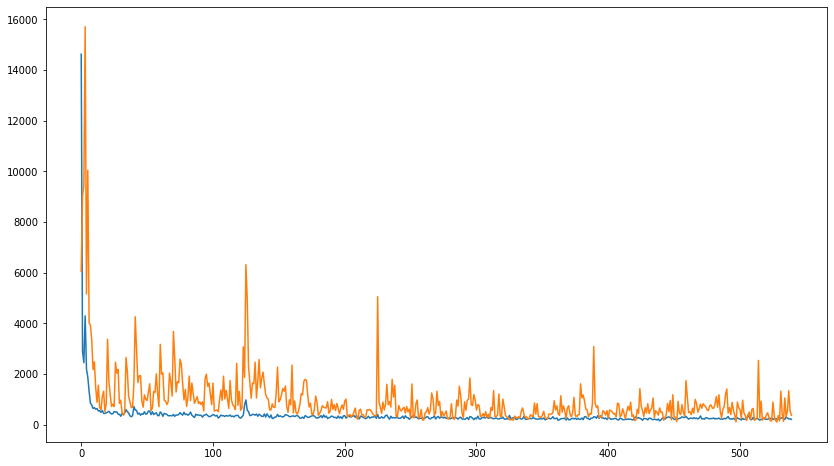

In [57]:
show_history(history)

### Price Optimization Demonstration

In [106]:
def predict_next_week(model, data):
    pred = model.predict(data)[0][0]
    
    return pred

def forecast(model, data, prices, window_size=config.window_size, batch_size=config.batch_size, buffer_size=config.buffer_size):
    data = data[['scaled_sales', 'scaled_price', 'sales']].copy()
    predictions = []
    for price in prices:
        data = data.append({'scaled_sales':0, 'scaled_price': scaler.transform([[0, price]])[0, 1]}, ignore_index = True)
        current_week = create_windowed_dataset(data.iloc[-(config.batch_size + config.window_size):], with_label=True)
        next_week_sales = predict_next_week(model, current_week)
        predictions.append(next_week_sales)
        data['sales'].iloc[-1] = next_week_sales
        
    return predictions


In [41]:
# model = tf.keras.models.load_model("../model/demand_forecasting")

2022-06-03 16:56:41.459996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-03 16:56:41.481998: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-03 16:56:41.491421: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (manfred): /proc/driver/nvidia/version does not exist
2022-06-03 16:56:41.779048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
from utils3 import ModelPipeline

In [42]:
# class ModelPipeline:
#     def __init__(self, model, data_pipeline):
#         self.model = model
#         self.data_pipeline = data_pipeline
        
#     def predict_next_week(self, model, data):
#         return self.model.predict(data)[0][0]

#     def forecast(self, data, prices):
#         data = self.data_pipeline.rescale(data)
#         data = data[['scaled_sales', 'scaled_price', 'sales']].copy()
#         predictions = []
#         for price in prices:
#             data = data.append({'scaled_sales':0, 'scaled_price': self.data_pipeline.scaler.transform([[0, price]])[0, 1]}, ignore_index = True)
#             current_week = self.data_pipeline.create_windowed_dataset(data.iloc[-(self.data_pipeline.batch_size + self.data_pipeline.window_size):], with_label=True, rescale=False)
#             next_week_sales = self.predict_next_week(self.model, current_week)
#             predictions.append(next_week_sales)
#             data['sales'].iloc[-1] = next_week_sales

#         return predictions

In [48]:
pipeline = ModelPipeline(model, data_pipeline)

In [49]:
joblib.dump(pipeline, "../model/demand_forecasting/pipeline.joblib")

INFO:tensorflow:Assets written to: ram://08a16ca7-e382-451a-b818-52ac47cafd4d/assets


INFO:tensorflow:Assets written to: ram://08a16ca7-e382-451a-b818-52ac47cafd4d/assets


['../model/demand_forecasting/pipeline.joblib']

In [109]:
predicted_sales = pipeline.forecast(valid, [312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355,
                                          312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355,
                                          312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355,
                                          312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 
                                         ])
plt.plot(predicted_sales)
print(np.mean(predicted_sales))

/home/manfred/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/manfred/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/manfred/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/manfred/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/manfred/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with f

AttributeError: module 'matplotlib' has no attribute 'path'

<Figure size 432x288 with 0 Axes>

In [110]:
# No discount at all
# predicted_sales = forecast(model, valid, [312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355,
#                                           312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355,
#                                           312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355,
#                                           312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 
#                                          ])
plt.plot(predicted_sales)
print(np.mean(predicted_sales))

AttributeError: module 'matplotlib' has no attribute 'path'

<Figure size 432x288 with 0 Axes>

In [112]:
# No discount at all
predicted_sales = forecast(model, valid, [312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 300000.685355, 300000.685355,
                                          312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 300000.685355, 300000.685355,
                                          312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 300000.685355, 300000.685355,
                                          312089.685355, 312089.685355, 312089.685355, 312089.685355, 312089.685355, 300000.685355, 300000.685355,
                                         ])
plt.plot(predicted_sales)
print(np.mean(predicted_sales))

In [ ]:
# Discount on the first 2 weeks
predicted_sales = forecast(model, valid, [0, 0, 0, 0, 0, 0, 0,
                                          0, 0, 0, 0, 0, 0, 0,
                                          0, 0, 0, 0, 0, 0, 0,
                                          0, 0, 0, 0, 0, 0, 0,
                                         ])
plt.plot(predicted_sales)
print(np.mean(predicted_sales))

In [ ]:
valid